<a href="https://colab.research.google.com/github/malvarezgarcia1213-png/project-nlp-challenge/blob/main/NLP_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import pickle
import re

In [4]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [5]:
import joblib

modelo = joblib.load('/content/drive/MyDrive/last_fake_news_model.pkl')


In [ ]:

data = pd.read_csv('/content/data.csv')
print(data.columns)

Index(['label', 'title', 'text', 'subject', 'date'], dtype='object')


In [ ]:
import re
data["text_full"] = (data["title"].fillna('') + " " + data["text"].fillna('')).astype(str)

In [ ]:
# Limpieza básica del texto
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

data["text_clean"] = data["text_full"].apply(clean_text)

# Normalizar subject (en caso de diferencias como 'Politics', 'politicsNews', etc.)
def normalize_subject(s):
    s = str(s).lower().strip()
    if 'politic' in s or 'government' in s or 'left' in s:
        return 'politics'
    elif 'world' in s:
        return 'world'
    elif 'news' in s:
        return 'general'
    else:
        return 'other'

data["subject_norm"] = data["subject"].apply(normalize_subject)

In [ ]:
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39942 entries, 0 to 39941
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   label         39942 non-null  int64 
 1   title         39942 non-null  object
 2   text          39942 non-null  object
 3   subject       39942 non-null  object
 4   date          39942 non-null  object
 5   text_full     39942 non-null  object
 6   text_clean    39942 non-null  object
 7   subject_norm  39942 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.4+ MB


,0
label,0
title,0
text,0
subject,0
date,0
text_full,0
text_clean,0
subject_norm,0


In [ ]:
print(data.isnull().sum())

label           0
title           0
text            0
subject         0
date            0
text_full       0
text_clean      0
subject_norm    0
dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Definir X e y
X = data[["text_clean", "subject_norm"]]
y = data["label"]

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Preprocesamiento: TF-IDF + OneHot para subject
preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english'), "text_clean"),
        ("subject", OneHotEncoder(handle_unknown="ignore"), ["subject_norm"])
    ]
)

# Modelo
model = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression(max_iter=2000, C=0.5, class_weight="balanced"))
])

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Entrenar
model.fit(X_train, y_train)

# Evaluar
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9899862310677181
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3989
           1       0.99      0.99      0.99      4000

    accuracy                           0.99      7989
   macro avg       0.99      0.99      0.99      7989
weighted avg       0.99      0.99      0.99      7989



In [ ]:
# Revisar si hay textos iguales en train y test
train_texts = set(X_train)
test_texts = set(X_test)

duplicates = train_texts.intersection(test_texts)
print(f"Duplicados exactos entre train y test: {len(duplicates)}")


Duplicados exactos entre train y test: 1154


In [ ]:
data = data.drop_duplicates(subset=["text_clean"])

In [ ]:
fake_words = " ".join(data.loc[data.label == 0, "text_clean"]).split()
real_words = " ".join(data.loc[data.label == 1, "text_clean"]).split()

from collections import Counter

print("Top palabras en FAKE news:")
print(Counter(fake_words).most_common(20))

print("\nTop palabras en REAL news:")
print(Counter(real_words).most_common(20))


Top palabras en FAKE news:
[('the', 339667), ('to', 202742), ('of', 153051), ('and', 148558), ('a', 143430), ('in', 107499), ('that', 107364), ('s', 90287), ('is', 79813), ('trump', 67047), ('for', 65352), ('he', 61177), ('it', 56888), ('on', 56468), ('his', 45026), ('was', 44827), ('with', 43553), ('this', 37642), ('as', 36542), ('be', 34591)]

Top palabras en REAL news:
[('the', 445677), ('to', 234250), ('of', 191363), ('a', 183730), ('in', 170165), ('and', 167974), ('on', 103337), ('said', 91227), ('that', 81422), ('for', 76713), ('with', 51945), ('is', 51714), ('he', 50318), ('trump', 46183), ('as', 44764), ('by', 44658), ('was', 44328), ('us', 43153), ('it', 42928), ('has', 42793)]


In [ ]:
from sklearn.model_selection import GroupShuffleSplit

splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(data, groups=data["subject_norm"]))

train = data.iloc[train_idx]
test = data.iloc[test_idx]

X_train, X_test = train["text_clean"], test["text_clean"]
y_train, y_test = train["label"], test["label"]


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipeline_text = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=2000, stop_words="english")),
    ("clf", LogisticRegression(max_iter=2000, C=0.2, class_weight="balanced"))
])


In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline_text, data["text_clean"], data["label"], cv=cv, scoring="accuracy")
print("CV scores:", scores)
print("Mean CV:", scores.mean())


CV scores: [0.98215756 0.98243206 0.98023607 0.97735383 0.97899794]
Mean CV: 0.9802354926692554


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Fit the pipeline before making predictions
pipeline_text.fit(X_train, y_train)

# Predicciones
y_pred = pipeline_text.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy del modelo: {acc:.4f}")

# Reporte completo
print("\n📊 Classification report:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
print("\n🔹 Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

ValueError: Found input variables with inconsistent numbers of samples: [2, 27127]

In [ ]:
import numpy as np

# Extraer componentes del pipeline
clf = model.named_steps["clf"]
pre = model.named_steps["pre"]

# Obtener nombres de features
tfidf = pre.named_transformers_["text"]
ohe = pre.named_transformers_["subject"]

tfidf_features = tfidf.get_feature_names_out()
subject_features = ohe.get_feature_names_out(["subject_norm"])

# Concatenar todas las features
all_features = np.concatenate([tfidf_features, subject_features])

# Coeficientes del modelo
coefs = clf.coef_[0]

# Crear DataFrame ordenado por importancia
importance_df = pd.DataFrame({
    "feature": all_features,
    "importance": coefs
}).sort_values(by="importance", ascending=False)

print("🔝 Top 15 features que predicen NOTICIAS REALES (label=1):")
print(importance_df.head(15))

print("\n🔻 Top 15 features que predicen NOTICIAS FALSAS (label=0):")
print(importance_df.tail(15))


🔝 Top 15 features que predicen NOTICIAS REALES (label=1):
                 feature  importance
3787             reuters   11.633322
3894                said   10.559656
4864  washington reuters    7.027432
4658              trumps    6.078418
5002  subject_norm_world    5.348052
4861          washington    4.903341
3712          republican    4.312139
3360    president donald    3.644647
3790   reuters president    3.154897
4886           wednesday    2.878739
1223          democratic    2.789434
4267              states    2.763407
4666             tuesday    2.723937
3372        presidential    2.698209
1446                 edt    2.666493

🔻 Top 15 features que predicen NOTICIAS FALSAS (label=0):
                   feature  importance
4867                 watch   -2.178931
4018                   sen   -2.273058
601               breaking   -2.353660
270                america   -2.488540
1291                  didn   -2.513185
4765                    ve   -2.592296
1924              

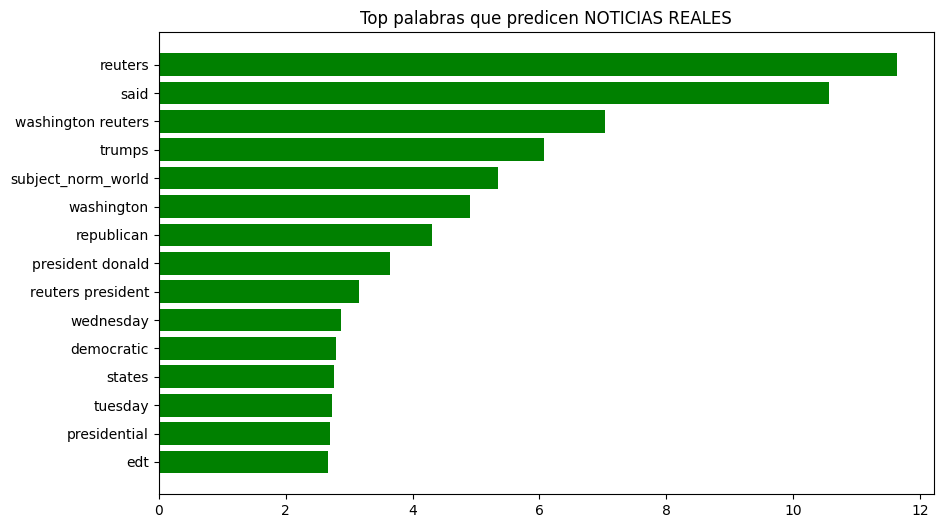

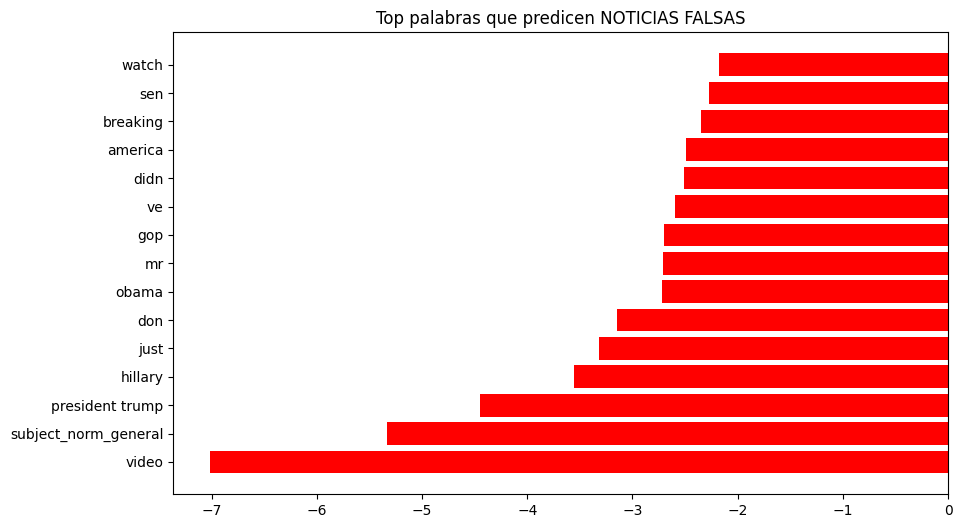

In [ ]:
import matplotlib.pyplot as plt

top_positive = importance_df.head(15)
top_negative = importance_df.tail(15)

plt.figure(figsize=(10,6))
plt.barh(top_positive["feature"], top_positive["importance"], color='green')
plt.title("Top palabras que predicen NOTICIAS REALES")
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(10,6))
plt.barh(top_negative["feature"], top_negative["importance"], color='red')
plt.title("Top palabras que predicen NOTICIAS FALSAS")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
X = data["text_clean"]
y = data["label"]

In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(
    data["text_clean"], data["label"], test_size=0.2, stratify=data["label"], random_state=42
)

pipeline_text = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words="english")),
    ("clf", LogisticRegression(max_iter=2000, C=0.5, class_weight="balanced"))
])

pipeline_text.fit(X_train, y_train)
y_pred = pipeline_text.predict(X_test)

print("Accuracy solo texto:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy solo texto: 0.9869821003880336
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3989
           1       0.98      0.99      0.99      4000

    accuracy                           0.99      7989
   macro avg       0.99      0.99      0.99      7989
weighted avg       0.99      0.99      0.99      7989



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import joblib

# Supongamos que tu pipeline se llama pipeline_text
model_path = '/content/drive/MyDrive/fake_news_model.pkl'
joblib.dump(pipeline_text, model_path)

print(f"Modelo guardado en: {model_path}")


Modelo guardado en: /content/drive/MyDrive/fake_news_model.pkl


In [ ]:
# ----------------------------
# Pipeline: reducir peso a features dominantes
# ----------------------------

import pandas as pd
import re
import numpy as np
from collections import Counter

# Cargar datos
data = pd.read_csv("/content/data.csv")

# ------------- Preprocesamiento -------------
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+','', text)           # quitar URLs
    text = re.sub(r'[^a-z0-9\s]', ' ', text)     # solo alfanuméricos
    text = re.sub(r'\s+', ' ', text).strip()
    return text

data['text_full'] = (data['title'].fillna('') + " " + data['text'].fillna('')).astype(str)
data['text_clean'] = data['text_full'].apply(clean_text)

# Normalizar subjects (ajusta reglas según tus nombres reales)
def normalize_subject(s):
    s = str(s).lower().strip()
    s = re.sub(r'[_\-\s]+', ' ', s)
    if 'politic' in s or 'government' in s or 'left' in s or 'right' in s:
        return 'politics'
    if 'world' in s:
        return 'world'
    if 'news' in s:
        return 'general'
    if s == '' or s=='nan':
        return 'missing'
    return s

if 'subject' in data.columns:
    data['subject_norm'] = data['subject'].fillna('missing').apply(normalize_subject)
else:
    data['subject_norm'] = 'missing'

# Eliminar duplicados exactos de texto (importante)
data = data.drop_duplicates(subset=['text_clean']).reset_index(drop=True)

# ------------- Split robusto -------------
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(data, groups=data['subject_norm']))
train = data.iloc[train_idx].reset_index(drop=True)
test  = data.iloc[test_idx].reset_index(drop=True)

X_train = train[['text_clean', 'subject_norm']]
y_train = train['label']
X_test  = test[['text_clean', 'subject_norm']]
y_test  = test['label']

# ------------- Pipeline inicial (texto + subject) -------------
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Setup inicial de TF-IDF (ajustable)
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2),
                        min_df=5, max_df=0.85, stop_words='english')

pre = ColumnTransformer([
    ('text', tfidf, 'text_clean'),
    ('subj', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['subject_norm'])
], transformer_weights={'text': 1.0, 'subj': 1.0})  # inicialmente igual peso

pipe = Pipeline([
    ('pre', pre),
    ('clf', LogisticRegression(max_iter=2000, C=0.5, class_weight='balanced'))
])

# Entrenar pipeline inicial
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print("=== Evaluación inicial ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# ------------- Inspeccionar features dominantes -------------
# Extraer TF-IDF features y coeficientes
clf = pipe.named_steps['clf']
preproc = pipe.named_steps['pre']
tf = preproc.named_transformers_['text']
ohe = preproc.named_transformers_['subj']

tf_features = tf.get_feature_names_out()
# OHE feature names (sólo si usamos sparse=False en OneHotEncoder)
try:
    subj_features = ohe.get_feature_names_out(['subject_norm'])
except Exception:
    # fallback para versiones antiguas
    subj_features = ["subject_" + str(c) for c in ohe.categories_[0]]

# concatenar en el mismo orden que ColumnTransformer produce
all_features = np.concatenate([tf_features, subj_features])

coefs = clf.coef_[0]
feat_imp = pd.DataFrame({'feature': all_features, 'coef': coefs})
feat_imp = feat_imp.sort_values('coef', ascending=False).reset_index(drop=True)

print("\nTop 10 features (pos => impulsa label=1):")
print(feat_imp.head(10))
print("\nTop 10 features (neg => impulsa label=0):")
print(feat_imp.tail(10))

# ¿Cuánto aporte tienen las features de subject?
n_subj = len(subj_features)
subj_coefs = feat_imp[feat_imp['feature'].isin(subj_features)]
print("\nSubject features contribution (abs sum):", subj_coefs['coef'].abs().sum())
print("Top subject coefs:")
print(subj_coefs.sort_values('coef', key=lambda s: s.abs(), ascending=False).head(10))

# ------------- Si subject domina → reducir su peso -------------
# Vamos a: 1) reducir transformer_weights de subject, 2) eliminar top tokens problemáticos
# Detectar tokens de texto con coef absoluto muy alto
text_imp = feat_imp[~feat_imp['feature'].isin(subj_features)].copy()
text_imp['abscoef'] = text_imp['coef'].abs()
# Tomar top_k tokens que dominan (ajusta k)
top_k = 40
top_tokens = text_imp.sort_values('abscoef', ascending=False).head(top_k)['feature'].tolist()
print("\nTop tokens a considerar eliminar/ignorar:", top_tokens[:20])

# ------------- Estrategia: añadir estos tokens a stop_words y reducir peso al subject -------------
# Construir nuevo vectorizer con stop_words extendido
from sklearn.feature_extraction import text as text_module
extra_stop = set(top_tokens)
# usar stop_words predefinidas + extra
english_stop = text_module.ENGLISH_STOP_WORDS
extended_stop = list(set(english_stop).union(extra_stop)) # Convert set to list

tfidf2 = TfidfVectorizer(max_features=3000, ngram_range=(1,2),
                         min_df=5, max_df=0.8, stop_words=extended_stop)

# Reducir peso del subject (por ejemplo 0.2)
pre2 = ColumnTransformer([
    ('text', tfidf2, 'text_clean'),
    ('subj', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['subject_norm'])
], transformer_weights={'text': 1.0, 'subj': 0.2})

pipe2 = Pipeline([
    ('pre', pre2),
    ('clf', LogisticRegression(max_iter=2000, C=0.1, class_weight='balanced'))  # más regularización
])

# Entrenar pipeline ajustado
pipe2.fit(X_train, y_train)
y_pred2 = pipe2.predict(X_test)
print("\n=== Evaluación tras reducir pesos (subject weight=0.2, quitar top tokens) ===")
print("Accuracy:", accuracy_score(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

# Cross-validation honesta (estratificada)
from sklearn.model_selection import cross_val_score, StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe2, data[['text_clean','subject_norm']], data['label'], cv=cv, scoring='accuracy')
print("CV scores (pipe2):", scores)
print("CV mean:", scores.mean(), "std:", scores.std())

# ------------- Alternativa: eliminar subject por completo y ver baseline solo texto -------------
from sklearn.pipeline import make_pipeline
pipe_text_only = make_pipeline(
    TfidfVectorizer(max_features=3000, ngram_range=(1,2),
                    min_df=5, max_df=0.8, stop_words='english'),
    LogisticRegression(max_iter=2000, C=0.1, class_weight='balanced')
)
pipe_text_only.fit(X_train['text_clean'], y_train)
y_pred_text = pipe_text_only.predict(X_test['text_clean'])
print("\n=== Evaluación solo texto (sin subject) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_text))
print(classification_report(y_test, y_pred_text))

=== Evaluación inicial ===
Accuracy: 0.23624309392265194
              precision    recall  f1-score   support

           0       1.00      0.24      0.38      9050
           1       0.00      0.00      0.00         0

    accuracy                           0.24      9050
   macro avg       0.50      0.12      0.19      9050
weighted avg       1.00      0.24      0.38      9050


Top 10 features (pos => impulsa label=1):
              feature       coef
0             reuters  10.529302
1                said  10.374409
2  washington reuters   7.147719
3          washington   5.487568
4          republican   5.049477
5    president donald   3.694792
6   reuters president   3.519812
7          democratic   3.148837
8           wednesday   2.945289
9             tuesday   2.849105

Top 10 features (neg => impulsa label=0):
                    feature      coef
4992                    sen -3.079072
4993                  watch -3.142516
4994                     mr -3.429980
4995  subject_n

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.p


=== Evaluación tras reducir pesos (subject weight=0.2, quitar top tokens) ===
Accuracy: 0.6044198895027625
              precision    recall  f1-score   support

           0       1.00      0.60      0.75      9050
           1       0.00      0.00      0.00         0

    accuracy                           0.60      9050
   macro avg       0.50      0.30      0.38      9050
weighted avg       1.00      0.60      0.75      9050



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.p

CV scores (pipe2): [0.95936982 0.96006081 0.9577056  0.95521769 0.95618521]
CV mean: 0.9577078250000095 std: 0.0018340047150451442

=== Evaluación solo texto (sin subject) ===
Accuracy: 0.9396685082872929
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      9050
           1       0.00      0.00      0.00         0

    accuracy                           0.94      9050
   macro avg       0.50      0.47      0.48      9050
weighted avg       1.00      0.94      0.97      9050



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import joblib

# Supongamos que tu pipeline se llama pipeline_text
model_path = '/content/drive/MyDrive/fake_news_model.pkl'
joblib.dump(pipeline_text, model_path)

print(f"Modelo guardado en: {model_path}")

Modelo guardado en: /content/drive/MyDrive/fake_news_model.pkl
